In [389]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

## Train EDA

In [390]:
df = pd.read_csv('./data/train.csv')

In [391]:
df.shape

(1617, 85)

In [392]:
df.head()

,MDR,ID,NHC,start_neutropenico,start_FN,days_between,days_in_hospital,hospital_stay_w_FN,prev_hospital_stay,birth_year,...,TOBRAMICINA_NEB_.MG.,VANCOMICINA_.MG.,Auto_TP,Alo_TP,room_list,mucositis,cito_group_3,cito_group_1,cito_group_2,Past_positive_result_from
0,0,374-1,404,2007-12-11,2008-01-01,nan,28,1,3,1941,...,0,8000,1,0,E02403,0,1,0,0,Culture
1,0,398-1,1897,2007-12-28,2008-01-01,nan,8,1,6,1935,...,0,0,0,0,G06512,0,0,0,0,NEGATIVE
2,0,403-1,556,2008-01-01,2008-01-01,nan,2,1,1,1980,...,0,0,1,0,E02407,1,0,0,0,NEGATIVE
3,0,407-1,454,2008-01-05,2008-01-05,nan,1,1,9,1986,...,0,0,0,0,"G06508, U10102, UHE211",0,0,0,0,NEGATIVE
4,0,394-1,1615,2007-12-22,2008-01-06,nan,17,1,5,1943,...,0,0,0,0,"G06502, G08501",0,0,0,0,Culture


In [393]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1617 entries, 0 to 1616
Data columns (total 85 columns):
MDR                                         1617 non-null int64
ID                                          1617 non-null object
NHC                                         1617 non-null int64
start_neutropenico                          1617 non-null object
start_FN                                    1617 non-null object
days_between                                832 non-null float64
days_in_hospital                            1617 non-null int64
hospital_stay_w_FN                          1617 non-null int64
prev_hospital_stay                          1617 non-null int64
birth_year                                  1617 non-null int64
Gender                                      1617 non-null object
emergency                                   1617 non-null int64
num_movements                               1617 non-null int64
num_consult                                 1617 non-nul

In [394]:
print("Number of unique patients:", df.NHC.nunique())

Number of unique patients: 785


In [395]:
print("Number of observations with MDR:", df.MDR.sum())

Number of observations with MDR: 86


In [396]:
print("Number of distinct patients with MDR:", df[df.MDR==1].NHC.nunique())

Number of distinct patients with MDR: 80


### Missing values

There are 3 columns with missigns:
* `days_between`
* `days_after_anti`
* `room_list`

#### Days between and days after antibiotic

In [397]:
df['d_days_between'] = df['days_between'].apply(lambda x: 0 if np.isnan(x) else 1)
df['d_days_after_anti'] = df['days_after_anti'].apply(lambda x: 0 if np.isnan(x) else 1)

#### Room list

Split room list into dummies

In [398]:
# Write a proxy method to be passed to `pipe`
def agg_assign(gb, fdict):
    data = {
        (cl, nm): gb[cl].agg(fn)
        for cl, d in fdict.items()
        for nm, fn in d.items()
    }
    pd.options.display.float_format = '{:.0f}'.format
    return pd.DataFrame(data)

In [399]:
# Identical dictionary passed to `agg`
funcs = {
    'room_list': {
        'count': 'count',
    },
    'MDR': {
        'sum': 'sum',
    }
}

In [400]:
df.groupby('room_list').pipe(agg_assign, fdict=funcs).reset_index().sort_values(('MDR', 'sum'), ascending=False).head(20)

room_list       MDR
                                    count sum
403                          G06514    12   3
71                           E02401    50   3
109                          E02405    41   2
279                          G02407    19   2
294                          G02409    25   2
82                           E02402    45   2
217                          G02207     5   2
150                          E02408    41   2
249                          G02403    20   2
418  G07112, G09204, G09205, G7C112     1   1
81   E02401, G02407, G06510, G06514     2   1
76                   E02401, G02402     3   1
73                   E02401, E02408     1   1
209          G02204, G02409, U02215     1   1
87                   E02402, G02401     1   1
210          G02204, G03301, G06501     1   1
216          G02206, G05301, G7C112     1   1
58           E01506, G06507, G06510     1   1
301          G02410, G06501, G06511     1   1
222                          G02208     4   1

In [401]:
for idx, row in df.iterrows():
    try:
        num_rooms = len(row['room_list'].split(","))
    except:
        if np.isnan(row['room_list']):
            num_rooms = 0
        else:
            num_rooms = 1
    df.loc[idx, 'num_rooms'] = num_rooms
    
df.drop('room_list', axis=1, inplace=True)

In [402]:
funcs = {
    'num_rooms': {
        'count': 'count',
    },
    'MDR': {
        'sum': 'sum',
    }
}

df_numrooms = df.groupby('num_rooms').pipe(agg_assign, fdict=funcs).reset_index()

In [403]:
df_numrooms['%MDR'] = df_numrooms[('MDR','sum')]/df_numrooms[('num_rooms','count')]*100
df_numrooms

num_rooms       MDR %MDR
            count sum     
0         0   333  13    4
1         1   796  36    5
2         2   299  23    8
3         3   120   7    6
4         4    36   5   14
5         5    20   1    5
6         6     8   1   12
7         7     3   0    0
8         8     2   0    0

In [404]:
import datetime as datetime

In [405]:
dates_columns = ["start_neutropenico","start_FN", "birth_year"]
for c in dates_columns:
    if c != "birth_year":
        df[c] = pd.to_datetime(df[c],format='%Y-%m-%d')
    else:
        df[c] = pd.to_datetime(df[c],format="%Y")

In [409]:
df['age'] = df["start_FN"].dt.year - df["birth_year"].dt.year

In [410]:
df

,MDR,ID,NHC,start_neutropenico,start_FN,days_between,days_in_hospital,hospital_stay_w_FN,prev_hospital_stay,birth_year,...,Alo_TP,mucositis,cito_group_3,cito_group_1,cito_group_2,Past_positive_result_from,d_days_between,d_days_after_anti,num_rooms,age
0,0,374-1,404,2007-12-11,2008-01-01,nan,28,1,3,1941-01-01,...,0,0,1,0,0,Culture,0,1,1,67
1,0,398-1,1897,2007-12-28,2008-01-01,nan,8,1,6,1935-01-01,...,0,0,0,0,0,NEGATIVE,0,1,1,73
2,0,403-1,556,2008-01-01,2008-01-01,nan,2,1,1,1980-01-01,...,0,1,0,0,0,NEGATIVE,0,0,1,28
3,0,407-1,454,2008-01-05,2008-01-05,nan,1,1,9,1986-01-01,...,0,0,0,0,0,NEGATIVE,0,0,3,22
4,0,394-1,1615,2007-12-22,2008-01-06,nan,17,1,5,1943-01-01,...,0,0,0,0,0,Culture,0,1,2,65
5,0,392-1,1723,2008-01-08,2008-01-08,nan,20,1,1,1941-01-01,...,0,0,0,0,0,NEGATIVE,0,1,0,67
6,0,396-1,1521,2007-12-28,2008-01-12,nan,22,1,3,1951-01-01,...,0,0,1,0,0,Blood culture,0,1,1,57
7,0,406-1,232,2008-01-11,2008-01-12,nan,9,1,3,1950-01-01,...,0,1,1,1,1,NEGATIVE,0,1,1,58
8,0,415-1,38,2008-01-12,2008-01-12,nan,2,1,4,1973-01-01,...,0,0,0,0,0,NEGATIVE,0,0,1,35
9,0,388-1,544,2007-12-25,2008-01-13,nan,27,1,1,1947-01-01,...,0,0,1,0,0,Culture,0,1,1,61


In [382]:
df['start_FN']

0      2008-01-01
1      2008-01-01
2      2008-01-01
3      2008-01-05
4      2008-01-06
5      2008-01-08
6      2008-01-12
7      2008-01-12
8      2008-01-12
9      2008-01-13
10     2008-01-13
11     2008-01-15
12     2008-01-16
13     2008-01-18
14     2008-01-18
15     2008-01-19
16     2008-01-19
17     2008-01-20
18     2008-01-20
19     2008-01-21
20     2008-01-22
21     2008-01-24
22     2008-01-24
23     2008-01-25
24     2008-01-26
25     2008-01-29
26     2008-01-31
27     2008-01-31
28     2008-02-01
29     2008-02-03
          ...    
1587   2013-03-10
1588   2013-03-11
1589   2013-03-11
1590   2013-03-14
1591   2013-03-14
1592   2013-03-17
1593   2013-03-18
1594   2013-03-22
1595   2013-03-22
1596   2013-03-23
1597   2013-03-26
1598   2013-03-26
1599   2013-03-26
1600   2013-03-31
1601   2013-03-31
1602   2013-04-04
1603   2013-04-05
1604   2013-04-06
1605   2013-04-09
1606   2013-04-09
1607   2013-04-11
1608   2013-04-12
1609   2013-04-15
1610   2013-04-17
1611   201

Bins decided as follows:
* 0 rooms
* 1 room
* 2 rooms
* +2 rooms

In [356]:
df['num_rooms_b'] = df['num_rooms'].apply(lambda x: x if x <= 2 else 3)

In [357]:
funcs = {
    'num_rooms_b': {
        'count': 'count',
    },
    'MDR': {
        'sum': 'sum',
    }
}

df_numrooms = df.groupby('num_rooms_b').pipe(agg_assign, fdict=funcs).reset_index()
df_numrooms['%MDR'] = df_numrooms[('MDR','sum')]/df_numrooms[('num_rooms_b','count')]*100
df_numrooms

num_rooms_b       MDR %MDR
              count sum     
0           0   333  13    4
1           1   796  36    5
2           2   299  23    8
3           3   189  14    7

In [358]:
df.describe()

,MDR,NHC,days_between,days_in_hospital,hospital_stay_w_FN,prev_hospital_stay,birth_year,emergency,num_movements,num_consult,...,Auto_TP,Alo_TP,mucositis,cito_group_3,cito_group_1,cito_group_2,d_days_between,d_days_after_anti,num_rooms,num_rooms_b
count,1617,1617,832,1617,1617,1617,1617,1617,1617,1617,...,1617,1617,1617,1617,1617,1617,1617,1617,1617,1617
mean,0,948,76,13,2,3,1957,0,1,5,...,0,0,0,0,0,0,1,1,1,1
std,0,591,128,17,1,3,16,0,1,9,...,0,0,0,0,0,0,0,0,1,1
min,0,1,3,0,1,0,1919,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25%,0,522,11,1,1,1,1946,0,0,0,...,0,0,0,0,0,0,0,0,1,1
50%,0,810,37,9,1,2,1954,0,0,2,...,0,0,0,0,0,0,1,1,1,1
75%,0,1565,83,16,2,4,1968,1,1,5,...,0,0,0,1,0,0,1,1,2,2
max,1,2016,1307,166,8,20,1993,1,12,91,...,2,2,1,1,1,1,1,1,8,3


In [359]:
df.columns

Index(['MDR', 'ID', 'NHC', 'start_neutropenico', 'start_FN', 'days_between',
       'days_in_hospital', 'hospital_stay_w_FN', 'prev_hospital_stay',
       'birth_year', 'Gender', 'emergency', 'num_movements', 'num_consult',
       'share_room_MDR', 'dummy_LAM', 'dummy_others.LL',
       'dummy_Cancer.linfoproliferativo', 'dummy_SMD', 'dummy_LAL',
       'dummy_EICH', 'dummy_Leucemia.cronica', 'dummy_SMPC',
       'dummy_Cancer.solido', 'dummy_LMC', 'dummy_TLPT', 'dummy_others.LM',
       'dummy_Mieloma.like', 'dummy_LLC', 'antibiotic_count',
       'days_after_anti', 'AMIKACINA_.MG.', 'AMOXICILINA_.MG.',
       'AMPICILINA_.MG.', 'AZITROMICINA_VIAL_.MG.', 'AZTREONAM_.MG.',
       'CEFAZOLINA_.MG.', 'CEFIXIMA_.MG.', 'CEFOTAXIMA_.MG.',
       'CEFOXITINA_.MG.', 'CEFTAROLINA_FOSAMIL_.MG.', 'CEFTAZIDIMA_.MG.',
       'CEFTIBUTENO_.MG.', 'CEFTOLOZANO_.UND.', 'CEFTRIAXONA_.MG.',
       'CEFUROXIMA.AXETILO_.MG.', 'CIPROFLOXACINO_.MG.', 'CLARITROMICINA_.MG.',
       'CLINDAMICINA_.MG.', 'CLOXA

In [360]:
# drop non necessary columns
df.drop('Gender', axis=1, inplace=True)
df.drop('ID', axis=1, inplace=True)
df.drop('NHC', axis=1, inplace=True)
df.drop('Past_positive_result_from', axis=1, inplace=True)
df.drop('start_neutropenico', axis=1, inplace=True)
df.drop('start_FN', axis=1, inplace=True)

df.drop('days_between', axis=1, inplace=True)
df.drop('days_after_anti', axis=1, inplace=True)

In [361]:
df = df[df.columns[~df.columns.str.contains('_.MG')]]
df = df[df.columns[~df.columns.str.contains('_.UND')]]

In [363]:
df

,MDR,days_in_hospital,hospital_stay_w_FN,prev_hospital_stay,birth_year,emergency,num_movements,num_consult,share_room_MDR,dummy_LAM,...,Auto_TP,Alo_TP,mucositis,cito_group_3,cito_group_1,cito_group_2,d_days_between,d_days_after_anti,num_rooms,num_rooms_b
0,0,28,1,3,1941,0,0,10,0,0,...,1,0,0,1,0,0,0,1,1,1
1,0,8,1,6,1935,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
2,0,2,1,1,1980,0,0,1,0,0,...,1,0,1,0,0,0,0,0,1,1
3,0,1,1,9,1986,1,1,0,0,0,...,0,0,0,0,0,0,0,0,3,3
4,0,17,1,5,1943,0,2,2,0,0,...,0,0,0,0,0,0,0,1,2,2
5,0,20,1,1,1941,0,2,5,0,0,...,0,0,0,0,0,0,0,1,0,0
6,0,22,1,3,1951,0,0,2,0,1,...,0,0,0,1,0,0,0,1,1,1
7,0,9,1,3,1950,0,0,2,0,0,...,1,0,1,1,1,1,0,1,1,1
8,0,2,1,4,1973,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
9,0,27,1,1,1947,0,0,5,1,0,...,1,0,0,1,0,0,0,1,1,1


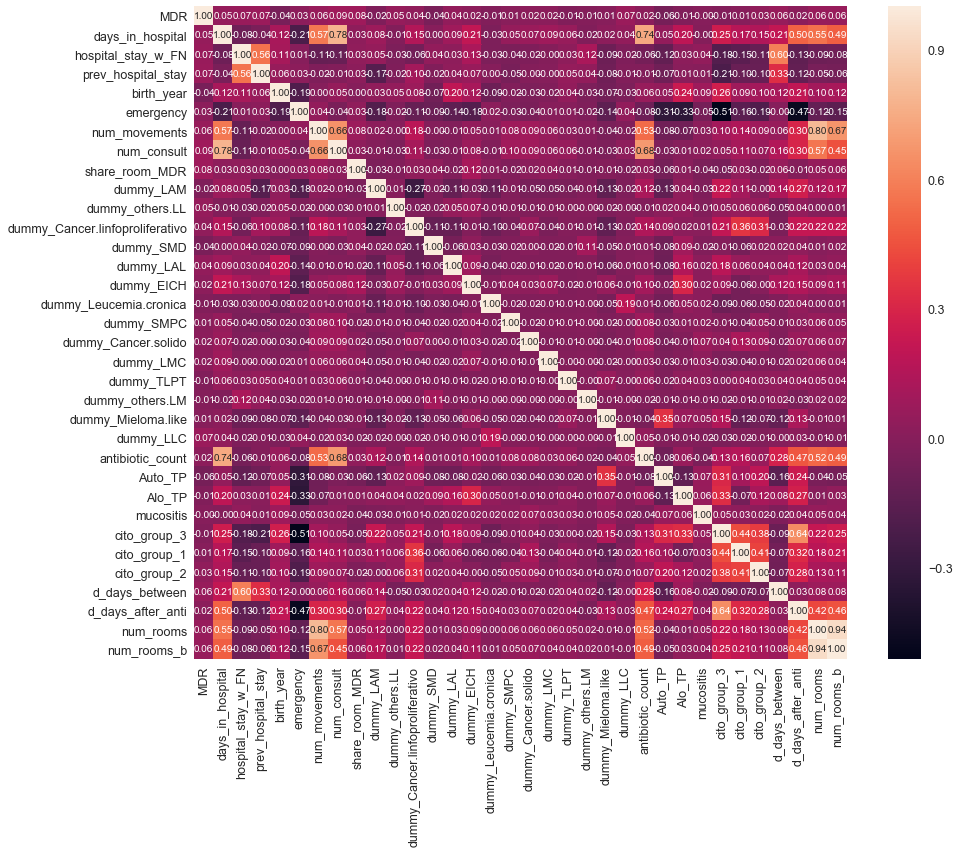

In [362]:
# correlation matrix
cols = df.columns
corrmat = df.corr()
f, ax = plt.subplots(figsize=(15, 12))
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()